## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quadrature
import pickle

import warnings

warnings.filterwarnings('ignore')

In [2]:
# h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
h5pydir = 'h5py_dat/'

# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [3]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

## Parameters and Constants

In [4]:
spline_pars = {'k': 3, 's': 0.0}

z_pk = 0.0; #redshift at which Pk is determined
pk_max = 1.e2; #maximum k for Pk
kk = np.logspace(-4,np.log10(pk_max),500)
f_idm_dr = 1.0
omega0_cdm = 0.12038;
xi = 0.3
# BM_KS = ['10']
# BM_KS = [str(round(n,1)) for n in np.geomspace(1, 10, 5)]
BM_KS = [str(round(n,1)) for n in np.geomspace(1, 10, 5)]


# A_recs = [1e8, 1e10, 1e12, 1e14, 1e16, 1e18]
A_recs = [1e11, 1e12, 1e14]
# A_recs = [1e11]


T_rec = 6.0e5
# k = 10 #use one k mode for now


In [5]:
BM_KS

['1.0', '1.8', '3.2', '5.6', '10.0']

## Functions

In [6]:
def scientific_format(x):
    s = '%.1e' % x
    mantissa, exponent = s.split('e')
    return r'${} \times 10^{{{}}}$'.format(mantissa, int(exponent))    

## Read in h5py files

In [8]:
k = BM_KS[0]

In [9]:
#Get data for case with no recoupling
data_file=h5pydir+'class_testing_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])
    clTT_no_rec = np.array(f['cmb']['tt'])
    ll_no_rec = np.array(f['cmb']['ell'])


In [17]:
#Get data for LambdaCDM
data_file=h5pydir+'class_testing_LambdaCDM.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data_lambdaCDM = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    phi_data_lambdaCDM = np.array(f['scalar']['k='+str(k)]['phi'])
    
    phi_lambdaCDM = UnivariateSpline(tau_data_lambdaCDM, phi_data_lambdaCDM, **spline_pars)
    phi_dot_lambdaCDM = phi_lambdaCDM.derivative()

    Pks_lambdaCDM = np.array(f['power_spectrum']['Pk'])
    kks_lambdaCDM = np.array(f['power_spectrum']['kk'])

    z_data_lambdaCDM = np.flip(np.array(f['thermodynamics']['z']))

    bkg_zs_lambdaCDM = np.array(f['background']['z'])
    clTT_lambdaCDM = np.array(f['cmb']['tt'])
    ll_lambdaCDM = np.array(f['cmb']['ell'])


In [22]:
#Get data for cases with recoupling

delta_chi_dot_arr = []
phi_dot_arr = []
Pk_arr = []
kappa_dot_taus_arr = []
kappa_dot_zs_arr = []
z_arr = []
tau_arr = []
thermo_tau_arr = []
theta_dr_arr = []
rho_idr_arr = []
rho_idm_arr = []
theta_chi_dot_arr = []
theta_chi_arr = []
clTT_arr = []
ll_arr = []
for A_rec in A_recs:
    data_file=h5pydir+'class_testing_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'r') as f:
        tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
        delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
        phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
        kappa_dot_data = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
        z_data = np.flip(np.array(f['thermodynamics']['z']))
        thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
        cx2_data = np.flip(np.array(f['thermodynamics']['c_idm_dr^2']))

        theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
        theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])

        psi_data = np.array(f['scalar']['k='+str(k)]['psi'])

        rho_idr_data = np.array(f['background']['(.)rho_idr'])
        rho_idm_data = np.array(f['background']['(.)rho_idm_dr'])
        bkg_tau_data = np.array(f['background']['conf. time [Mpc]'])

        rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
        rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)

        delta_chi = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
        delta_chi_dot = delta_chi.derivative()
        delta_chi_ddot = delta_chi_dot.derivative()

        phi = UnivariateSpline(tau_data, phi_data, **spline_pars)
        phi_dot = phi.derivative()
        phi_ddot = phi_dot.derivative()

        theta_chi = UnivariateSpline(tau_data, theta_data, **spline_pars)
        theta_chi_dot = theta_chi.derivative()
        theta_dr = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

        psi = UnivariateSpline(tau_data, psi_data, **spline_pars)
        cx2_chi = UnivariateSpline(thermo_tau_data, cx2_data, **spline_pars)

        kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)
        kappa_dot_zs = UnivariateSpline(np.flip(z_data), np.flip(kappa_dot_data), **spline_pars)
        thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)

        a_data = 1/(1+z_data)
        a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
        aprime = a.derivative()

        Pks = np.array(f['power_spectrum']['Pk'])
        kks = np.array(f['power_spectrum']['kk'])

        clTT_data = np.array(f['cmb']['tt'])
        ll_data = np.array(f['cmb']['ell'])

        delta_chi_dot_arr.append(delta_chi_dot)
        Pk_arr.append(Pks)
        kappa_dot_taus_arr.append(kappa_dot_taus)
        kappa_dot_zs_arr.append(kappa_dot_zs)
        z_arr.append(z_data)
        tau_arr.append(tau_data)
        phi_dot_arr.append(phi_dot)
        thermo_tau_arr.append(thermo_taus)
        theta_dr_arr.append(theta_dr)
        rho_idr_arr.append(rho_idr)
        rho_idm_arr.append(rho_idm)
        theta_chi_arr.append(theta_chi)
        theta_chi_dot_arr.append(theta_chi_dot)
        clTT_arr.append(clTT_data)
        ll_arr.append(ll_data)

In [23]:
tau_tests = np.geomspace(tau_data[0],tau_data[-1], int(1e4))

In [24]:
Rdark_arr = [4/3*rho_idr_arr[i](7e-2)/rho_idm_arr[i](7e-2) for i in range(len(rho_idr_arr))]

## Recoupling rate calculation

In [25]:
def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, xi_idr = 0.3, sigma_fac = 0.001):

    sigma = sigma_fac*T_rec
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr 
    T_idr = (xi_idr * 2.73) * (1+z)
    delta = T_idr - T_rec
    delta = delta/sigma
    gauss = np.exp(-pow(delta,2)/2)/np.sqrt(2*np.pi)

    return base_rate * (1 + A_rec / sigma * gauss)

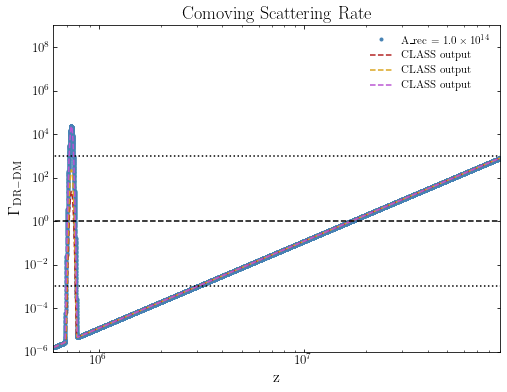

In [26]:
z_data = np.geomspace(1e-3,1e8,int(1e5))

# a_idm_dr = 3e5

plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[-1], T_rec=6e5, sigma_fac=0.01), '.', label='A_rec = {}'.format(scientific_format(A_recs[-1])))
# plt.plot(z_data, my_dmu_idm_dr(z_data, 0, a_idm_dr = a_idm_dr, T_rec=6e5, sigma_fac=0.01), '.', label='a_idm_dr = {}'.format(scientific_format(a_idm_dr)))


for i in range(len(A_recs)):
    plt.plot(z_data, kappa_dot_zs_arr[i](z_data), '--',label='CLASS output')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e5,9e7)
plt.ylim(1e-6,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

## CMB Spectrum

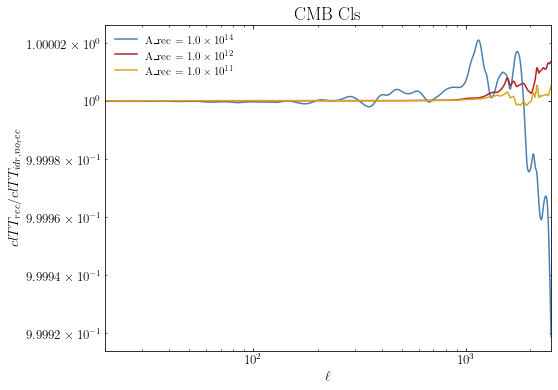

In [44]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(ll_arr[i][2:], clTT_arr[i][2:]/clTT_no_rec[2:], label='A_rec = ' + scientific_format(A_rec))

plt.xlim(2e1,2.5e3)
# plt.ylim(1e-6,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$clTT_{rec}/clTT_{idr, no_rec}$')
plt.title('CMB Cls')
plt.legend()
plt.show()


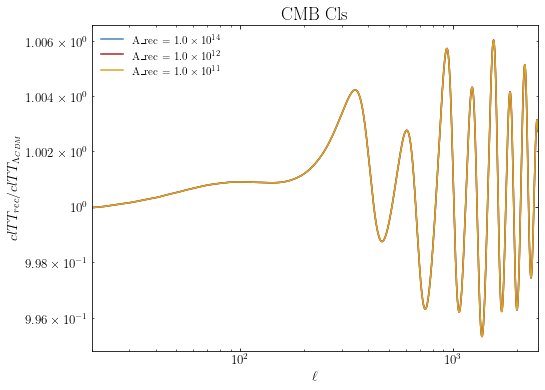

In [45]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(ll_arr[i][2:], clTT_arr[i][2:]/clTT_lambdaCDM[2:], label='A_rec = ' + scientific_format(A_rec))

plt.xlim(2e1,2.5e3)
# plt.ylim(1e-6,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$clTT_{rec}/clTT_{\Lambda_{CDM}}$')
plt.title('CMB Cls')
plt.legend()
plt.show()


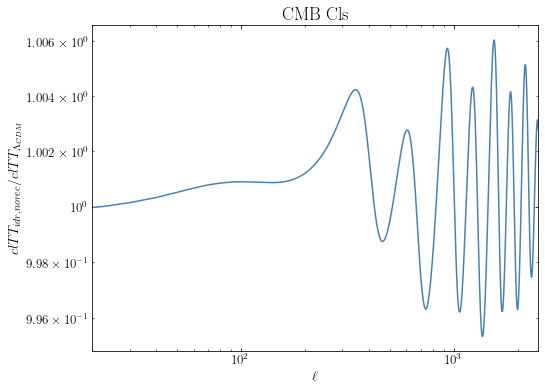

In [49]:
plt.plot(ll_no_rec[2:], clTT_no_rec[2:]/clTT_lambdaCDM[2:])

plt.xlim(2e1,2.5e3)
# plt.ylim(1e-6,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$clTT_{idr, no rec}/clTT_{\Lambda_{CDM}}$')
plt.title('CMB Cls')
plt.show()
